## GENERATIVE MODEL (VARIATIONAL AUTOENCODER)
An autoencoder is made up of two parts,encoder and decoder. 

In [1]:
#IMPORTING
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

In [2]:
#LOADING THE DATA 

face_data = []
for img in tqdm(os.listdir('../input/data/data')):
    path = '../input/data/data/{}'.format(img)
    
    image = plt.imread(path)
    image = image.astype('float32')
    face_data.append(image)
    
face_data = np.array(face_data)    

100%|██████████| 21551/21551 [03:10<00:00, 113.14it/s]


In [3]:
def show_img(dataset):
    fig, ax = plt.subplots(1,4)
    fig.set_size_inches(40, 20)
    for i in range(4,8):
        ax[i-4].imshow(dataset[i].reshape(64,64,3))
    plt.show()

In [4]:
len(face_data)

21551

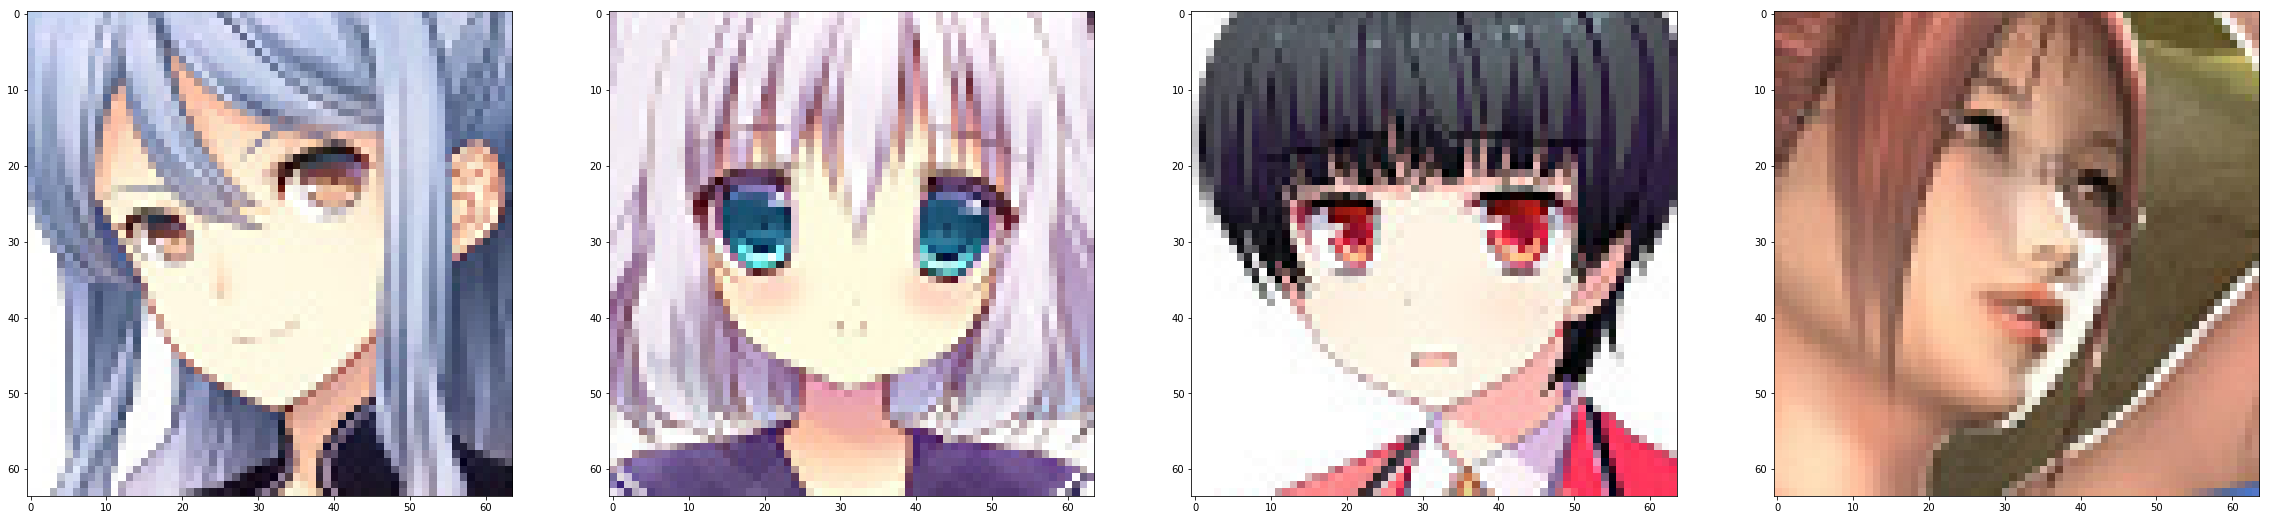

In [5]:
show_img(face_data)

In [6]:
import keras

from keras.models import Sequential, Model, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Add, Multiply
from keras.losses import mse, binary_crossentropy
import keras.backend as K

Using TensorFlow backend.


In [7]:
np.random.seed(20)

#NUMBER OF DIMENSIONS IN THE LATENT SPACE
latent_dims = 512

## Building the encoder

The encoder compresses the image via a series of convolutions into a smaller dimensional space (z).

The output is split into 2 blocks, the mean (mu) and log_variance (log_var), which are then recombined to predict a distribution rather than a value.

In [8]:
encoder_in = Input(shape=(64,64,3))  

encoder_l1 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=(64,64,3))(encoder_in)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)

encoder_l1 = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = Activation(LeakyReLU(0.2))(encoder_l2)

encoder_l3 = Conv2D(filters=256, kernel_size=5, strides=2, padding='same')(encoder_l2)
encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = Activation(LeakyReLU(0.2))(encoder_l3)


encoder_l4 = Conv2D(filters=512, kernel_size=5, strides=2, padding='same')(encoder_l3)
encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l4 = Activation(LeakyReLU(0.2))(encoder_l4)

flatten = Flatten()(encoder_l4)

encoder_dense = Dense(1024)(flatten)
encoder_dense = BatchNormalization()(encoder_dense)
encoder_out = Activation(LeakyReLU(0.2))(encoder_dense)


mu = Dense(latent_dims)(encoder_out)
log_var = Dense(latent_dims)(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model([encoder_in,epsilon], z)
encoder.summary()


/opt/conda/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Building a Decoder

In [9]:
decoder = Sequential()
decoder.add(Dense(1024, input_shape=(latent_dims,)))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Dense(8192))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Reshape(target_shape=(4,4,512)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))


decoder.add(Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('sigmoid'))

decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_7 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
batch_normalization_8 (Batch (None, 8192)              32768     
_________________________________________________________________
activation_8 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
__________

## Full Variational Autoencoder

In [10]:
# COMBINING ENCODER AND DECODER TO COMPLETE THE VARIATIONAL AUTO ENCODER

vae_preds = decoder(z)
vae = Model([encoder_in, epsilon], vae_preds)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Loss Functions

Reconstruction loss 
* Mean Squared Loss

kl_loss
* kullback leibler loss


In [11]:
def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help


In [12]:
vae.compile(optimizer='adam', loss=vae_loss , metrics=[reconstruction_loss, kl_loss])
# reconstruction_loss, kl_loss

In [13]:
training_set=face_data[:100]

In [30]:
vae.fit(training_set,training_set, epochs=500, batch_size=64)

Epoch 1/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0551 - reconstruction_loss: 0.0515 - kl_loss: 0.1187
Epoch 2/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0551 - reconstruction_loss: 0.0516 - kl_loss: 0.1174
Epoch 3/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0551 - reconstruction_loss: 0.0518 - kl_loss: 0.1091
Epoch 4/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0539 - reconstruction_loss: 0.0508 - kl_loss: 0.1050
Epoch 5/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0549 - reconstruction_loss: 0.0514 - kl_loss: 0.1175
Epoch 6/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0539 - reconstruction_loss: 0.0503 - kl_loss: 0.1210
Epoch 7/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0538 - reconstruction_loss: 0.0505 - kl_loss: 0.1123
Epoch 8/500
100/100 [==============================] - 0s 1ms/step - loss: 0.0537 - recons

## PREDICTIONS

In [14]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(40,40))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

## ORIGINAL FACES

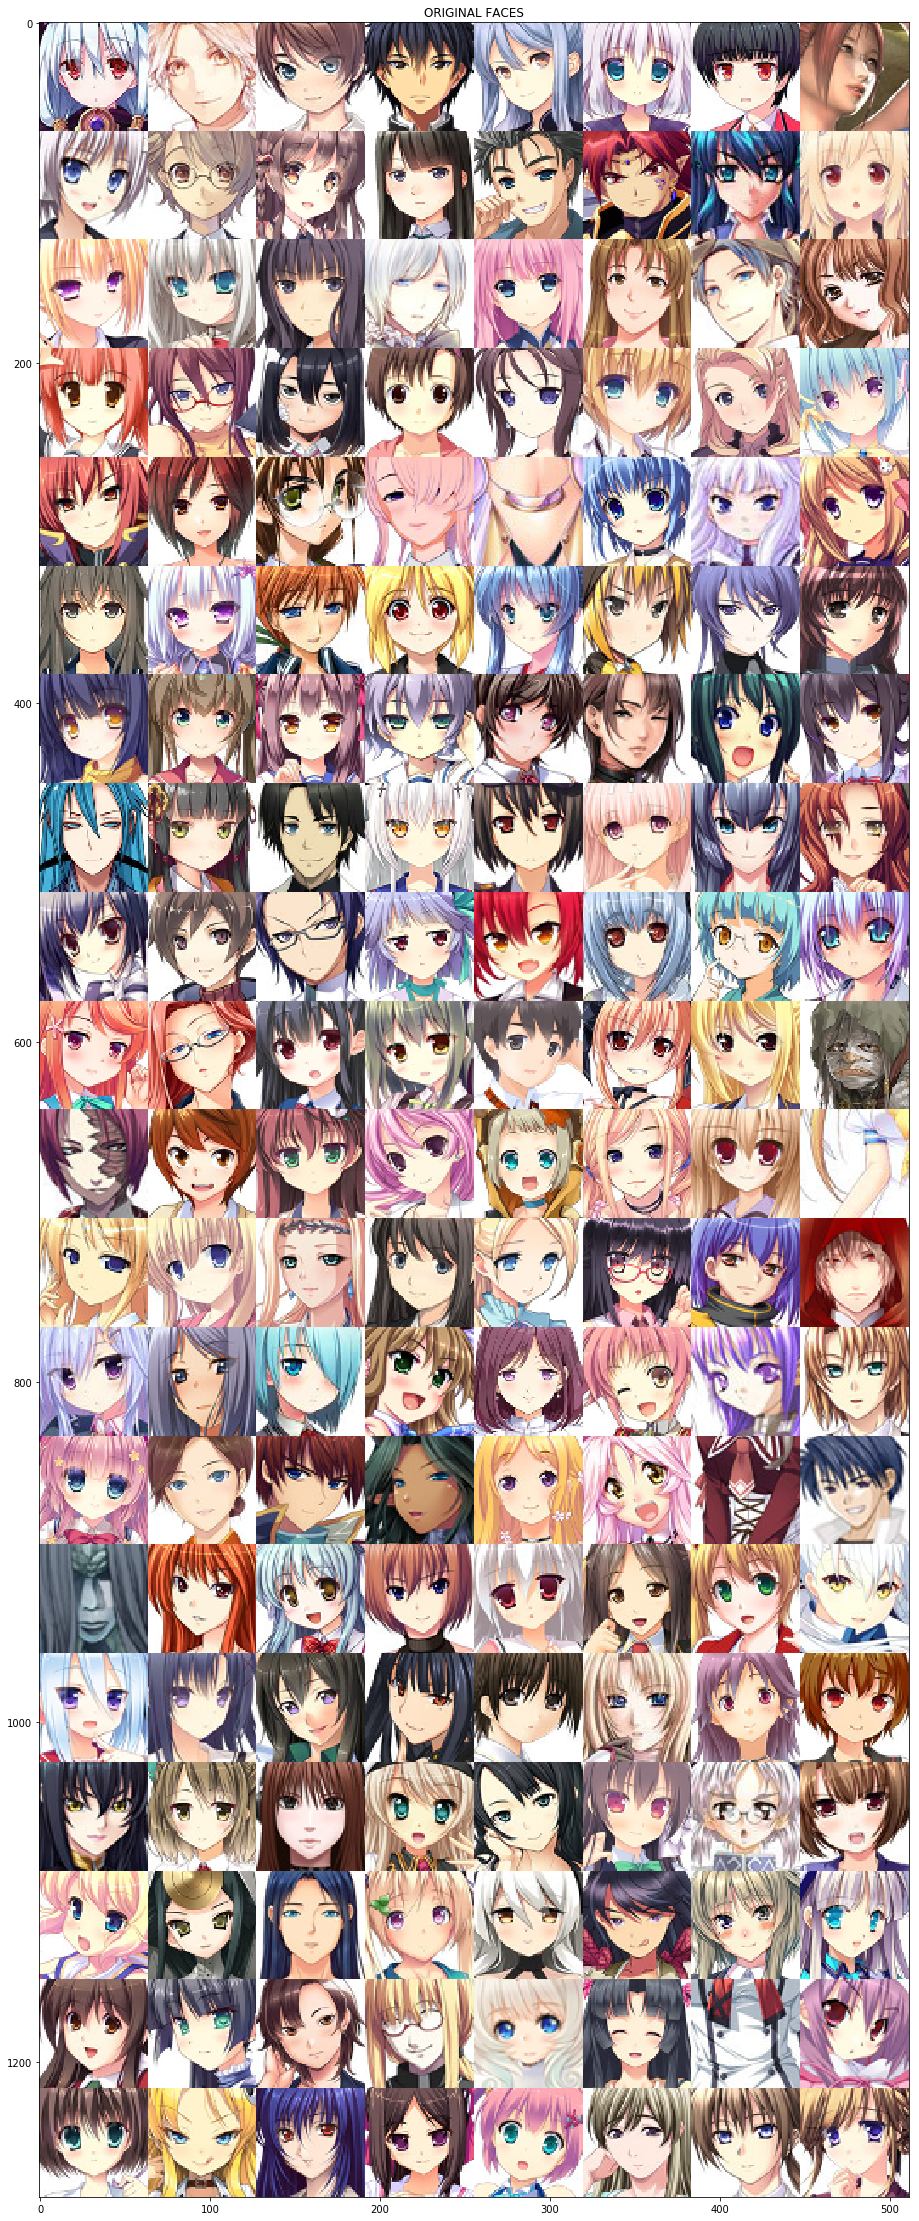

In [15]:
original_faces = face_data[:200]
plot_images(20,8,original_faces ,"ORIGINAL FACES")

## RECONSTRUCTED FACES or COMPRESSED (*which tries to replicate the original images*)

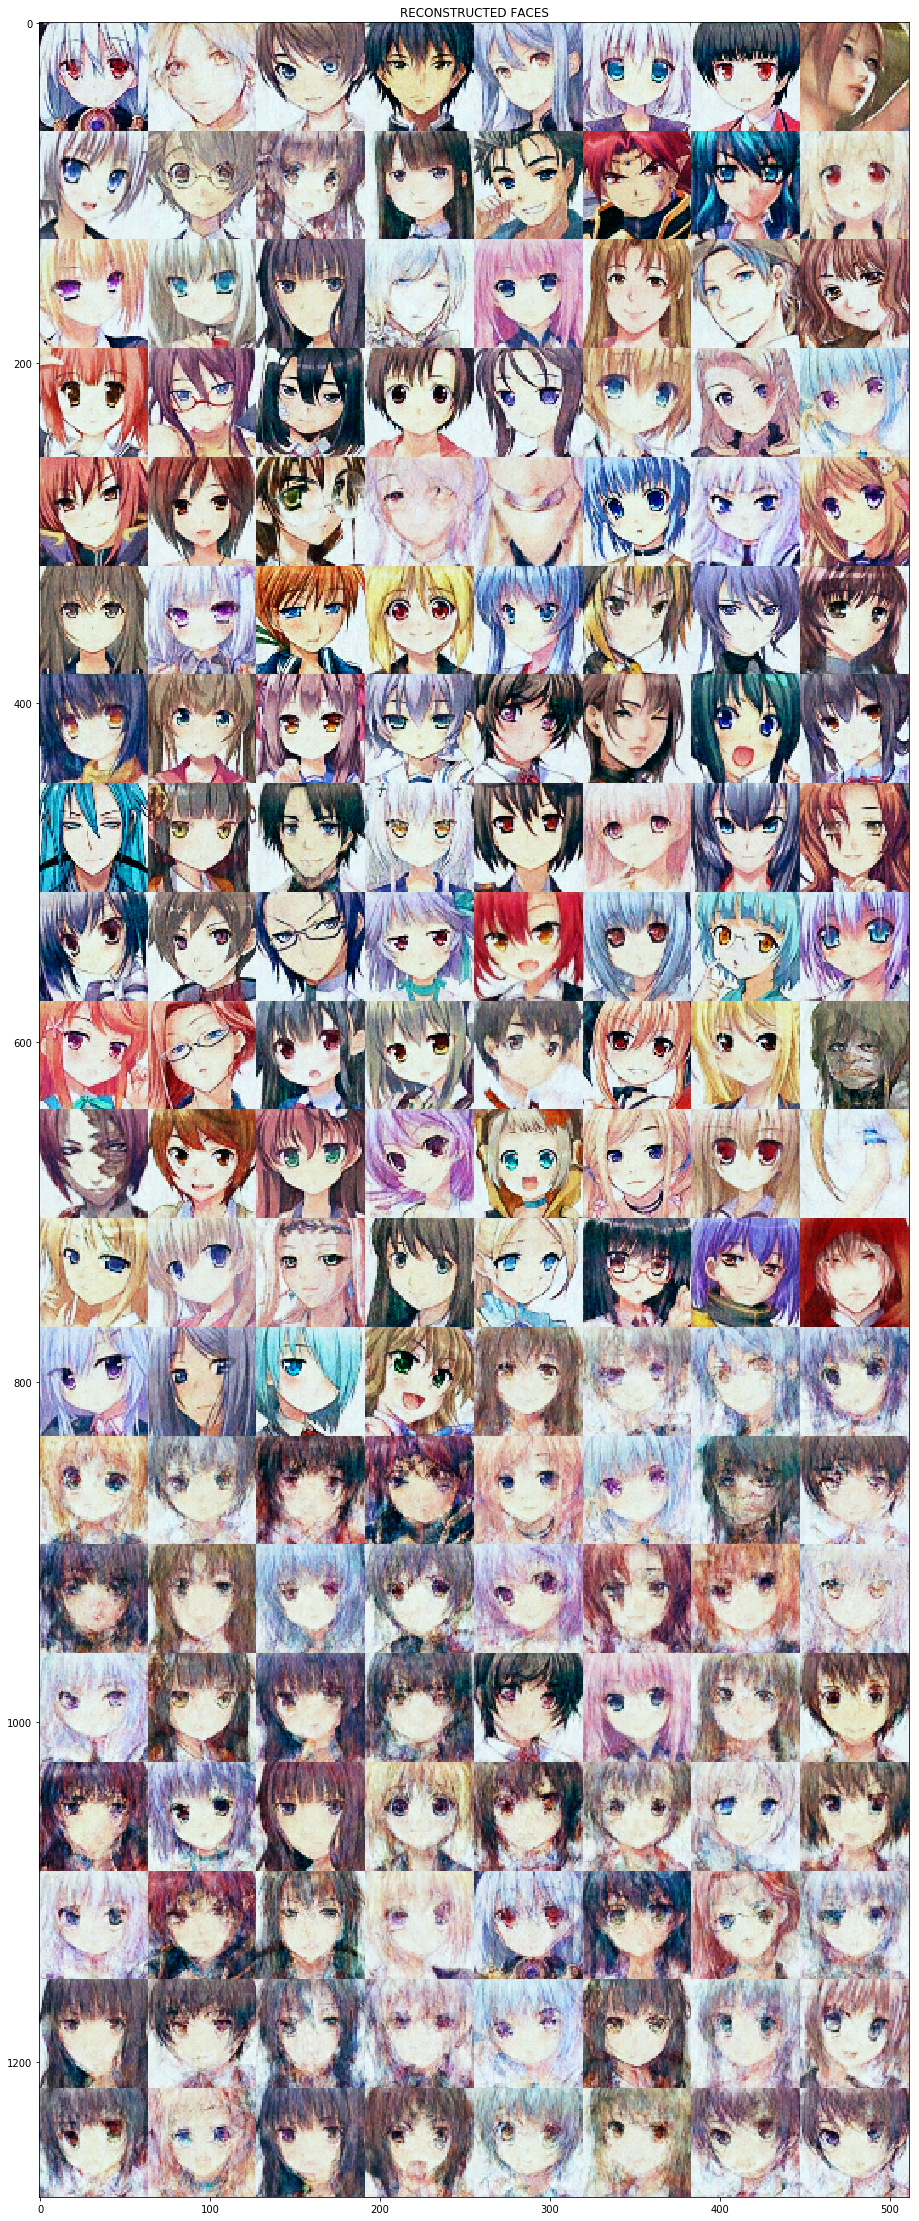

In [33]:
predictions  = vae.predict(face_data[:200])
plot_images(20,8,predictions, "RECONSTRUCTED FACES")

## NEWLY GENERATED FACES

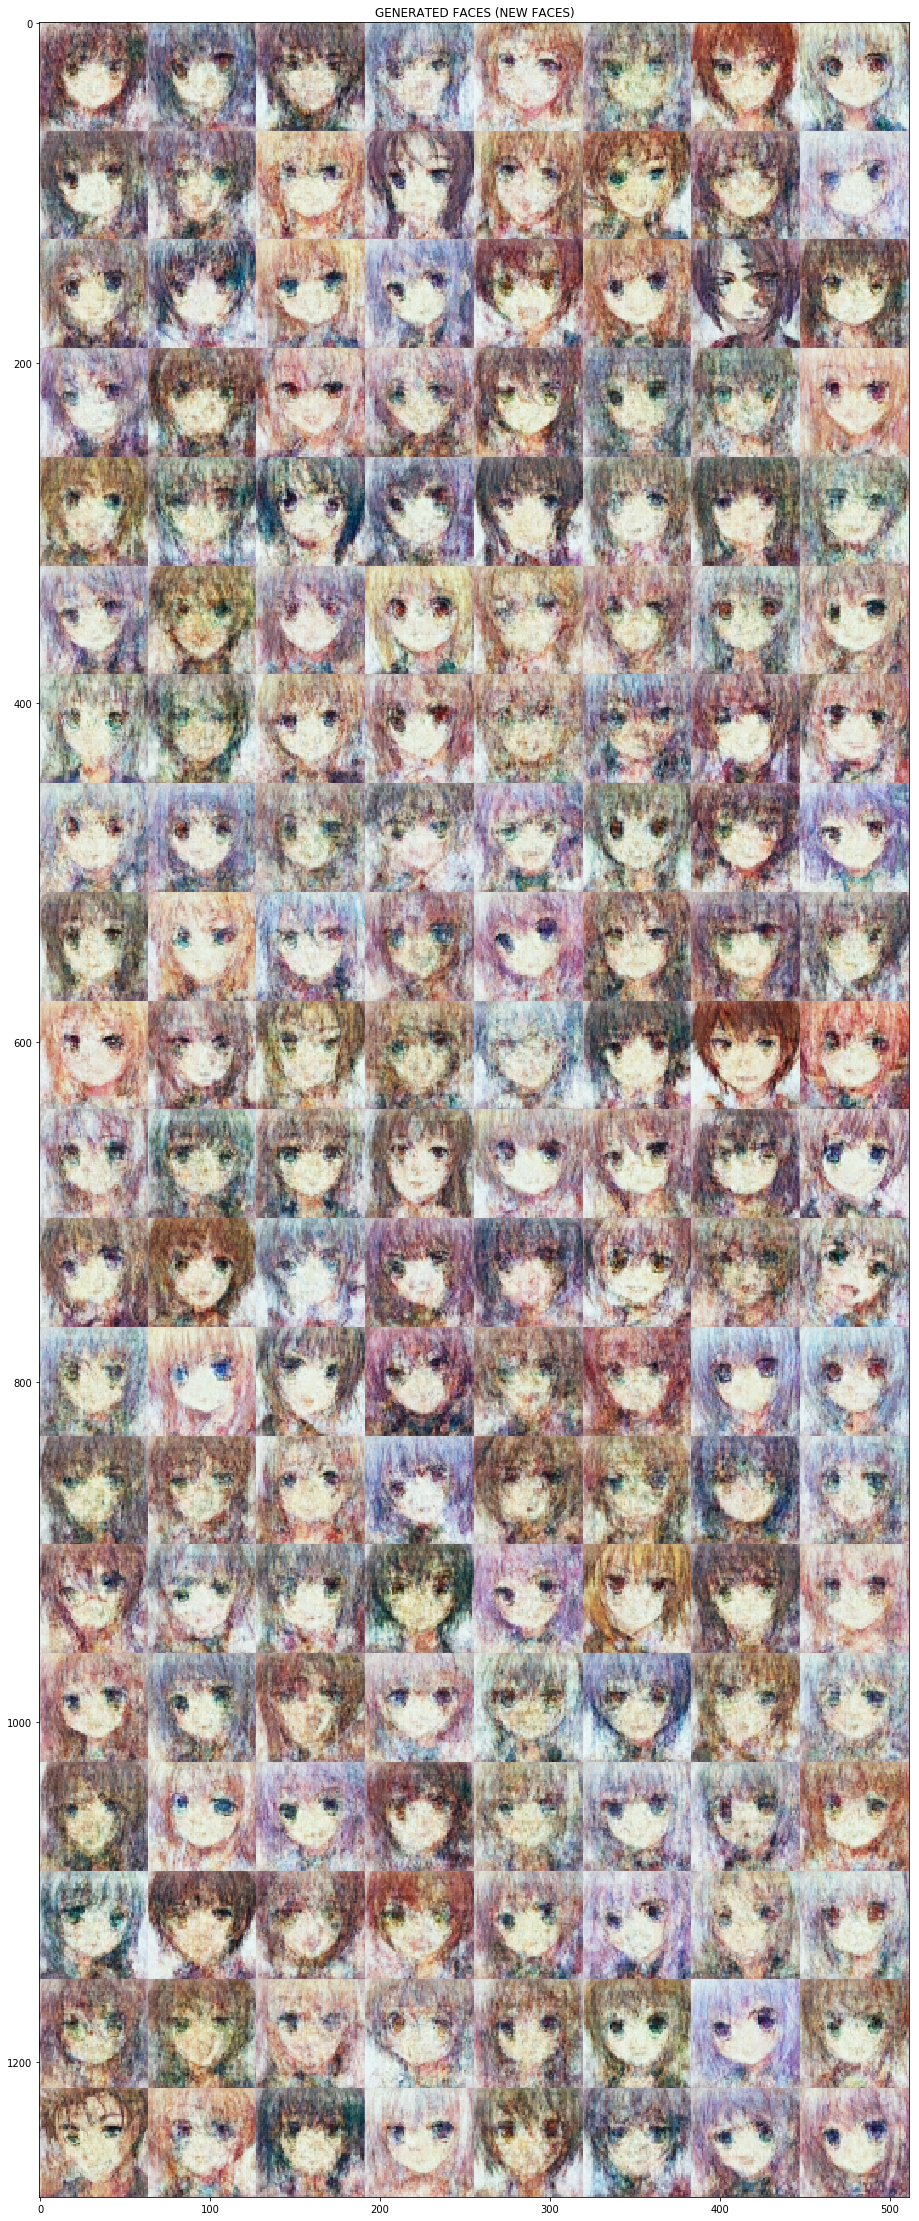

In [34]:
predictions= decoder.predict(np.random.randn(200, latent_dims))
plot_images(20,8,predictions, "GENERATED FACES (NEW FACES)")

## Conclusion

Our model has generated the images. Perhaps, I can improve the quality of predictions by adding a lot more encoding and decoding layers. VARIATIONAL AUTOENCODERS ARE GENERATIVE MODELS. THIS SHOWS US HOW CREATIVE A DEEP LEARNING MODEL CAN BE!
